### imports and general stuff

In [148]:
import Pkg
Pkg.activate("../../juliaccel.jl/")
using JuliAccel
using DifferentialEquations
using LaTeXStrings
using Plots
using Statistics
using ProgressBars
using Dates

  Activating project at `~/Polybox/ETH/ParticleAcceleratorModelling/juliaccel.jl`


# 1 Space charge map for continuous beam

### General Parameters

In [149]:
# using a proton
# Coupled differential equations:
# x=[x, x', x'']
# x[3] + kx(s)*x[1] - ϵx^2/x[1]^3 - K/(2(x[1]+y[1])) = 0
# y[3] + ky(s)*y[1] - ϵy^2/y[1]^3 - K/(2(x[1]+y[1])) = 0

# parameters;
I = 1e0                    # A
ϵ₀ = 8.854e-12              # F/m
m₀ = 1.6726219e-27          # kg
c = 3e8                     # m/s
q = 1.60217662e-19          # C
I0 = 4*π*ϵ₀*m₀*c / q        # A
I0 = 31e6                   # A for protons
β = 0.9                   # CHOSEN!
γ = 1/(1-(β)^2)
println(γ)
K = 2*I/(I0 * β^3 * γ^3)

# ϵx = √(varx*varx_prime - covarx)
# ϵy = √(vary*vary_prime - covary)

# x = rms_x/2
# y = rms_y/2


5.263157894736843


6.07018009646444e-10

In [150]:

#### DifferentialEquations
function elContBeamDiffEq!(du, u, p, t)
    x_env, x_env_prime, x_env_double_prime, y_env, y_env_prime, y_env_double_prime = u
    kx, ky, ϵx, ϵy, K = p

    du[1] = x_env_prime
    du[2] = x_env_double_prime
    du[3] = -kx * x_env + ϵx^2 / x_env^3 + K / (2 * (x_env + y_env))
    du[4] = y_env_prime
    du[5] = y_env_double_prime
    du[6] = -ky * y_env + ϵy^2 / y_env^3 + K / (2 * (x_env + y_env))
end

function calculateVariancesAndRMS(Γ)
    x = Γ[1,:]
    x_prime = Γ[2,:]
    y = Γ[3,:]
    y_prime = Γ[4,:]
    
    varx = var(x)
    vary = var(y)
    covx = cov(x, x_prime)
    covy = cov(y, y_prime)
    varxx_prime = varx * var(x_prime)
    varyy_prime = vary * var(y_prime)

    rms_x = sqrt(mean(x .^ 2))
    rms_y = sqrt(mean(y .^ 2))
    
    return varx, vary, varxx_prime, varyy_prime, covx, covy, rms_x, rms_y
end


calculateVariancesAndRMS (generic function with 1 method)

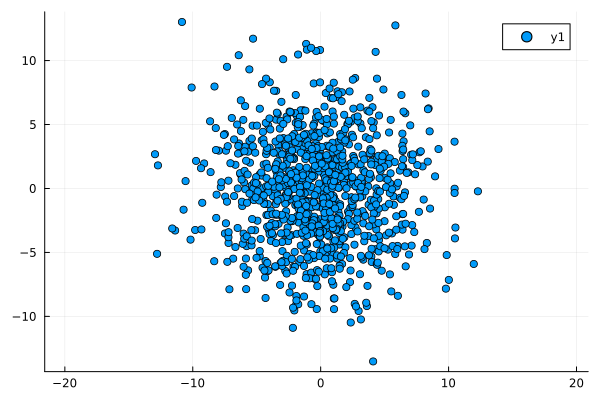

In [180]:
# generate particles
N_part = 1000 # number of particles

μ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ = [16.0 0.0 0.0 0.0 0.0 0.0;
     0.0 1.0 0.0 0.0 0.0 0.0;
     0.0 0.0 16.0 0.0 0.0 0.0;
     0.0 0.0 0.0 1.0 0.0 0.0;
     0.0 0.0 0.0 0.0 0.709 0.0;
     0.0 0.0 0.0 0.0 0.0 0.0981]

D = Gaussian(μ, Σ)

Γi = gen_distribution(D, N_part)
plot(Γi[1,:], Γi[3,:], seriestype=:scatter, aspect_ratio=:equal)


### Try to solve ODE directly

(14.570978325078215, 17.555277084611273, 14.558509849505276, 17.121474550375183, -0.338976855934409, 0.02672433696695244, 3.815794751055506, 4.187870764371584)
1.907897375527753   2.093935382185792


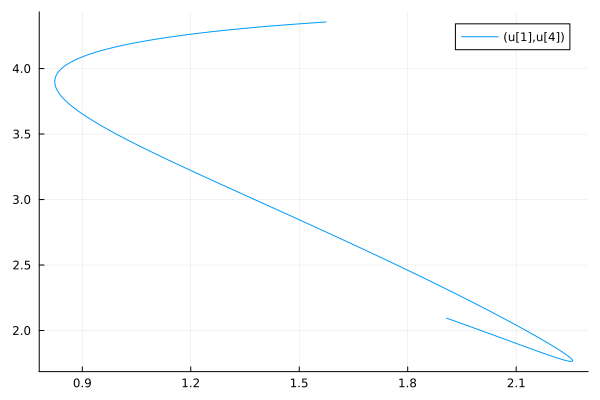

In [152]:
# SOLVE ODE DIRECTLY

var_x, var_y, varxx_prime, varyy_prime, covar_x, covar_y, rms_x, rms_y = calculateVariancesAndRMS(Γi)
println(calculateVariancesAndRMS(Γi))
println(rms_x/2, "   ",rms_y/2)
x0 = [rms_x/2, 0, 0]
y0 = [rms_y/2, 0, 0]
u0 = vcat(x0, y0)

ϵx = √((varxx_prime) - covar_x)
ϵy = √((varyy_prime) - covar_y)
kx = 1.
ky = 1.
p = [kx, ky, ϵx, ϵy, K]

tspan = (0.0, 5.)
prob = ODEProblem(elContBeamDiffEq!, u0, tspan, p)

# Solve the problem
sol = solve(prob)
plot(sol, vars=(1, 4))  # Plot x and y


### Solve with Juliaccel Matrix

In [ ]:
mad  = "pam-10.mad"
prob = "pam-10.japd"
n1 = 3
n2 = 6
n_max = n2 * (n1-1) + 1
pp = eval(:(@set_problem("x px y py z δ", $n1, $n2, $n_max)))

L = 0.1
kx = 1.
ky = 1.
K = 2*I/(I0 * β^3 * γ^3)
x_env = rms_x/2
y_env = rms_y/2
println(kx, " ", ky, " ", K, " ", x_env, " ", y_env)

# Ms  = gen_maps(mad, prob, symplectic=false)  ## THIS SHIT JUST DOESTNT WORK. DO EXPANSION MANUALLY
Ham_self = δ/β - sqrt((1/β+δ)^2 - px^2 - py^2 - 1/(β*γ)^2) + (K*(x^2 + y^2)/4(x_env^2 + y_env^2))
tps_expansion!(Ham_self)
Taylored_Ham_self = lie_transform(L*Ham_self, pp)
M_self = TaylorSeries.jacobian(Taylored_Ham_self)

1.0 1.0 6.07018009646444e-10 1.907897375527753 2.093935382185792


6×6 transpose(::Matrix{Float64}) with eltype Float64:
 1.0          -0.0916698  0.0           0.0        0.0   0.0
 3.78221e-12   1.0        0.0           0.0        0.0   0.0
 0.0           0.0        1.0          -0.0916698  0.0   0.0
 0.0           0.0        3.78221e-12   1.0        0.0   0.0
 0.0           0.0        0.0           0.0        1.0  -0.00343322
 0.0           0.0        0.0           0.0        0.0   1.0

In [ ]:
### Propagate and Plot

[ Info: Saved animation to /home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex10/JuliaccelMatrix.gif


Plots.AnimatedGif("/home/jonas/Polybox/ETH/ParticleAcceleratorModelling/Exercises_PAM/Ex10/JuliaccelMatrix.gif")
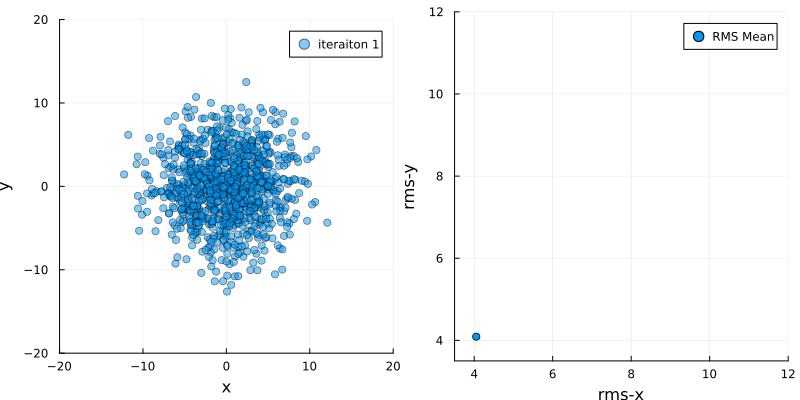

In [ ]:
# propagate:
N_iterations = 100
Γ = Array{Float64, 3}(undef, N_iterations+1, 6, 1000)
rmsx_array = Array{Float64, 1}(undef, N_iterations+1)
rmsy_array = Array{Float64, 1}(undef, N_iterations+1)
Γ[1, :, :] = Γi  
for i ∈ 1:N_iterations
    rmsx_array[i] = sqrt(mean(Γ[i,1,:] .^ 2))
    rmsy_array[i] = sqrt(mean(Γ[i,3,:] .^ 2))
    Γ[i+1,:,:] = M_self * Γ[i,:,:]
end
# Plot
anim = @animate for i ∈ 1:N_iterations
    p1 = plot(Γ[i,1,:], Γ[i,3,:], seriestype=:scatter, alpha=0.5, aspect_ratio=:equal, xlabel = "x", ylabel="y", label="iteraiton "*string(i))
    xlims!(-20, 20)
    ylims!(-20, 20)
    
    #p2 = scatter(1:i, rmsx_array[1:i], label="rms-x", xlabel="Iteration", ylabel="RMS")
    #scatter!(1:i, rmsy_array[1:i], label="rms-xy")
    p2 = plot(rmsx_array[1:i], rmsy_array[1:i], seriestype=:scatter, label="RMS Mean", xlabel="rms-x", ylabel="rms-y")
    xlims!(3.5, 12)
    ylims!(3.5, 12)
    
    plot(p1, p2, layout=(1, 2), size=(800, 400))
end

gif(anim, "JuliaccelMatrix.gif", fps = 15)